 首先，我们初始化合成图像，例如将其初始化为内容图像。 该合成图像是风格迁移过程中唯一需要更新的变量，即风格迁移所需迭代的模型参数。 然后，我们选择一个预训练的卷积神经网络来抽取图像的特征，其中的模型参数在训练中无须更新。 这个深度卷积神经网络凭借多个层逐级抽取图像的特征，我们可以选择其中某些层的输出作为内容特征或风格特征。选取的预训练的神经网络含有3个卷积层，其中第二层输出内容特征，第一层和第三层输出风格特征。


实线箭头和虚线箭头分别表示前向传播和反向传播


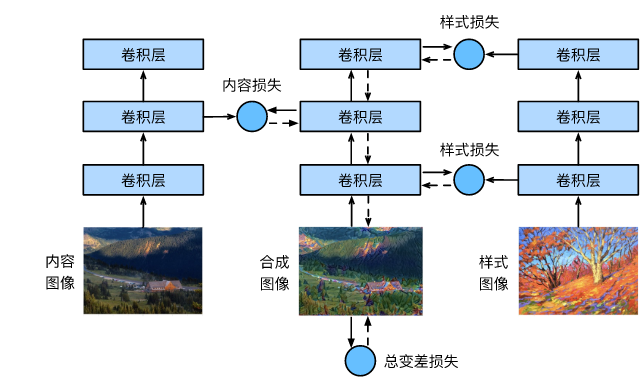

接下来，我们通过前向传播（实线箭头方向）计算风格迁移的损失函数，并通过反向传播（虚线箭头方向）迭代模型参数，即不断更新合成图像。 风格迁移常用的损失函数由3部分组成： 

（i）内容损失使合成图像与内容图像在内容特征上接近； 

（ii）风格损失使合成图像与风格图像在风格特征上接近； 

（iii）全变分损失则有助于减少合成图像中的噪点。 最后，当模型训练结束时，我们输出风格迁移的模型参数，即得到最终的合成图像。

In [ ]:
%matplotlib inline
!pip install d2l
!pip install matplotlib==3.0.0
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

d2l.set_figsize()
content_img = d2l.Image.open('/content/sample_data/cat.jpg')
d2l.plt.imshow(content_img);

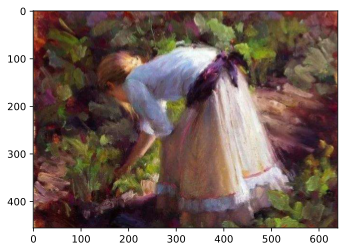

In [ ]:
style_img = d2l.Image.open('/content/sample_data/youhua.jpeg')
d2l.plt.imshow(style_img);

定义图像的预处理函数和后处理函数。 预处理函数preprocess对输入图像在RGB三个通道分别做标准化，并将结果变换成卷积神经网络接受的输入格式。 后处理函数postprocess则将输出图像中的像素值还原回标准化之前的值。 由于图像打印函数要求每个像素的浮点数值在0到1之间，我们对小于0和大于1的值分别取0和1。

In [8]:
rgb_mean = torch.tensor([0.485, 0.456, 0.406])
rgb_std = torch.tensor([0.229, 0.224, 0.225])

# 对输入图像在RGB三个通道分别做标准化，并将结果变换成卷积神经网络接受的输入格式
def preprocess(img, image_shape):
    transforms = torchvision.transforms.Compose([
        torchvision.transforms.Resize(image_shape),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=rgb_mean, std=rgb_std)])
    return transforms(img).unsqueeze(0) # img数据格式为（通道数*高*宽）

# 将输出图像中的像素值还原回标准化之前的值。由于图像打印函数要求每个像素的浮点数值在0到1之间，我们对小于0和大于1的值分别取0和1。
def postprocess(img):
    img = img[0].to(rgb_std.device)
    img = torch.clamp(img.permute(1, 2, 0) * rgb_std + rgb_mean, 0, 1) # 将数据格式变为（高*宽*通道数），方便对通道进行标准化
    print(img.shape)
    return torchvision.transforms.ToPILImage()(img.permute(2, 0, 1)) # 要将其还原为图像需要将其格式变为（通道数*高*宽）

使用基于ImageNet数据集预训练的VGG-19模型来抽取图像特征


In [ ]:
pretrained_net = torchvision.models.vgg19(pretrained=True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

为了抽取图像的内容特征和风格特征，我们可以选择VGG网络中某些层的输出。 一般来说，越靠近输入层，越容易抽取图像的细节信息；反之，则越容易抽取图像的全局信息。 为了避免合成图像过多保留内容图像的细节，我们选择VGG较靠近输出的层，即内容层，来输出图像的内容特征。 我们还从VGG中选择不同层的输出来匹配局部和全局的风格，这些图层也称为风格层。VGG网络使用了5个卷积块。 实验中，我们选择第四卷积块的最后一个卷积层作为内容层，选择每个卷积块的第一个卷积层作为风格层。 这些层的索引可以通过打印pretrained_net实例获取。

In [19]:
style_layers, content_layers = [0, 5, 10, 19, 28], [25]


使用VGG层抽取特征时，只需要用到从输入层到最靠近输出层的内容层或风格层之间的所有层。 下面构建一个新的网络net，它只保留需要用到的VGG的所有层。

In [ ]:
net = nn.Sequential(*[pretrained_net.features[i] for i in # max(content_layers + style_layers) + 1 = 29
                      range(max(content_layers + style_layers) + 1)])

给定输入X，如果我们简单地调用前向传播net(X)，只能获得最后一层的输出。 由于我们还需要中间层的输出，因此这里我们逐层计算，并保留内容层和风格层的输出。

In [ ]:
def extract_features(X, content_layers, style_layers):
    contents = []
    styles = []
    for i in range(len(net)):
        X = net[i](X)
        if i in style_layers:
            styles.append(X)
        if i in content_layers:
            contents.append(X)
    return contents, styles

get_contents函数对内容图像抽取内容特征； get_styles函数对风格图像抽取风格特征。 因为在训练时无须改变预训练的VGG的模型参数，所以可以在训练开始之前就提取出内容特征和风格特征。 由于合成图像是风格迁移所需迭代的模型参数，我们只能在训练过程中通过调用extract_features函数来抽取合成图像的内容特征和风格特征。

In [ ]:
def get_contents(image_shape, device):
    content_X = preprocess(content_img, image_shape).to(device)
    contents_Y, _ = extract_features(content_X, content_layers, style_layers)
    return content_X, contents_Y

def get_styles(image_shape, device):
    style_X = preprocess(style_img, image_shape).to(device)
    _, styles_Y = extract_features(style_X, content_layers, style_layers)
    return style_X, styles_Y

风格迁移的损失函数由内容损失、风格损失和全变分损失3部分组成。

#### 内容损失
内容损失通过平方误差函数衡量合成图像与内容图像在内容特征上的差异。 平方误差函数的两个输入均为extract_features函数计算所得到的内容层的输出。

In [ ]:
def content_loss(Y_hat, Y):
    # 我们从动态计算梯度的树中分离目标：
    # 这是一个规定的值，而不是一个变量。
    return torch.square(Y_hat - Y.detach()).mean()

#### 风格损失

风格损失与内容损失类似，也通过平方误差函数衡量合成图像与风格图像在风格上的差异。 为了表达风格层输出的风格，我们先通过extract_features函数计算风格层的输出。 假设该输出的样本数为1，通道数为$c$，高和宽分别为$h$和$w$，我们可以将此输出转换为矩阵$X$，其有$c$行和$hw$列。 这个矩阵可以被看作是由$c$个长度为$hw$的向量$\mathbf{x}_1, \ldots, \mathbf{x}_c$组合而成的。其中向量$x_i$代表了通道$i$上的风格特征。

在这些向量的格拉姆矩阵$\mathbf{X}\mathbf{X}^\top \in \mathbb{R}^{c \times c}$中，$i$行$j$列的元素$x_{ij}$即向量$x_i$和$x_j$的内积。它表达了通道$i$和通道$j$上风格特征的相关性。我们用这样的格拉姆矩阵来表达风格层输出的风格。 需要注意的是，当$hw$的值较大时，格拉姆矩阵中的元素容易出现较大的值。 此外，格拉姆矩阵的高和宽皆为通道数$c$。 为了让风格损失不受这些值的大小影响，下面定义的gram函数将格拉姆矩阵除以了矩阵中元素的个数，即$chw$。

In [ ]:
def gram(X):
    num_channels, n = X.shape[1], X.numel() // X.shape[1] # n = h*w
    X = X.reshape((num_channels, n))
    return torch.matmul(X, X.T) / (num_channels * n)

风格损失的平方误差函数的两个格拉姆矩阵输入分别基于合成图像与风格图像的风格层输出。这里假设基于风格图像的格拉姆矩阵gram_Y已经预先计算好了。

In [ ]:
def style_loss(Y_hat, gram_Y):
    return torch.square(gram(Y_hat) - gram_Y.detach()).mean()

#### 全变分损失

有时候，我们学到的合成图像里面有大量高频噪点，即有特别亮或者特别暗的颗粒像素。 一种常见的去噪方法是全变分去噪（total variation denoising）： 假设$x_{i,j}$表示坐标$(i, j)$处的像素值，降低全变分损失

$\sum_{i, j} \left|x_{i, j} - x_{i+1, j}\right| + \left|x_{i, j} - x_{i, j+1}\right|$

能够尽可能使邻近的像素值相似。

此处代码实现的是：

$\sum_{i, j} \left|x_{i+1, j} - x_{i+, j}\right| + \left|x_{i, j+1} - x_{i, j}\right|$

效果是一样的

In [ ]:
def tv_loss(Y_hat):
    return 0.5 * (torch.abs(Y_hat[:, :, 1:, :] - Y_hat[:, :, :-1, :]).mean() +
                  torch.abs(Y_hat[:, :, :, 1:] - Y_hat[:, :, :, :-1]).mean())

#### 损失函数

风格转移的损失函数是内容损失、风格损失和总变化损失的加权和。 通过调节这些权重超参数，我们可以权衡合成图像在保留内容、迁移风格以及去噪三方面的相对重要性。

In [ ]:

content_weight, style_weight, tv_weight = 1, 1e3, 10

def compute_loss(X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram):
    # 分别计算内容损失、风格损失和全变分损失
    contents_l = [content_loss(Y_hat, Y) * content_weight for Y_hat, Y in zip(
        contents_Y_hat, contents_Y)]
    styles_l = [style_loss(Y_hat, Y) * style_weight for Y_hat, Y in zip(
        styles_Y_hat, styles_Y_gram)]
    tv_l = tv_loss(X) * tv_weight
    # 对所有损失求和
    l = sum(10 * styles_l + contents_l + [tv_l])
    return contents_l, styles_l, tv_l, l

在风格迁移中，合成的图像是训练期间唯一需要更新的变量。因此，我们可以定义一个简单的模型SynthesizedImage，并将合成的图像视为模型参数。模型的前向传播只需返回模型参数即可。

In [ ]:
class SynthesizedImage(nn.Module):
    def __init__(self, img_shape, **kwargs):
        super(SynthesizedImage, self).__init__(**kwargs)
        self.weight = nn.Parameter(torch.rand(*img_shape))

    def forward(self):
        return self.weight

get_inits函数创建了合成图像的模型实例，并将其初始化为图像X。风格图像在各个风格层的格拉姆矩阵styles_Y_gram将在训练前预先计算好。

In [ ]:
def get_inits(X, device, lr, styles_Y):
    gen_img = SynthesizedImage(X.shape).to(device)
    gen_img.weight.data.copy_(X.data)
    trainer = torch.optim.Adam(gen_img.parameters(), lr=lr)
    styles_Y_gram = [gram(Y) for Y in styles_Y]
    return gen_img(), styles_Y_gram, trainer

在训练模型进行风格迁移时，不断抽取合成图像的内容特征和风格特征，然后计算损失函数。

In [ ]:
def train(X, contents_Y, styles_Y, device, lr, num_epochs, lr_decay_epoch):
    X, styles_Y_gram, trainer = get_inits(X, device, lr, styles_Y)
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_decay_epoch, 0.8)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[10, num_epochs],
                            legend=['content', 'style', 'TV'],
                            ncols=2, figsize=(7, 2.5))
    for epoch in range(num_epochs):
        trainer.zero_grad()
        contents_Y_hat, styles_Y_hat = extract_features(
            X, content_layers, style_layers)
        contents_l, styles_l, tv_l, l = compute_loss(
            X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram)
        l.backward()
        trainer.step()
        scheduler.step()
        if (epoch + 1) % 10 == 0:
            animator.axes[1].imshow(postprocess(X))
            animator.add(epoch + 1, [float(sum(contents_l)),
                                     float(sum(styles_l)), float(tv_l)])
    return X

 首先将内容图像和风格图像的高和宽分别调整为300和450像素，用内容图像来初始化合成图像。

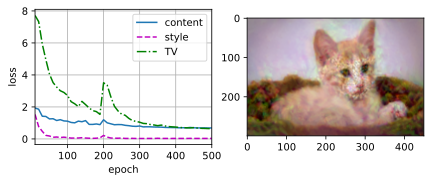

In [ ]:
device, image_shape = d2l.try_gpu(), (300, 450)
net = net.to(device)
content_X, contents_Y = get_contents(image_shape, device)
_, styles_Y = get_styles(image_shape, device)
output = train(content_X, contents_Y, styles_Y, device, 0.3, 500, 50)